In [1]:
import os
import pandas as pd
import soundfile
import yaml
from ASR.dataloader.dataset import Dataset, LSDataModule
from ASR.model import LitWav2Letter
import torchaudio
import scipy
import matplotlib.pyplot as plt
import torch
from scipy.io import wavfile
import auditory_cortex.regression as Reg
import numpy as np
import pickle

/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter_pretrained/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading pretrained weights

In [2]:
dir = os.getcwd()
conf_file = 'lightning.yaml'
manifest_file = os.path.join(dir,"conf",conf_file)
with open(manifest_file, 'r') as f:
    manifest = yaml.load(f, Loader=yaml.FullLoader)
model_param = manifest['model_param']
print(f"Batch size: {model_param['batch_size']}")

# Create model with pretrained weights....!
checkpoint = os.path.join(model_param["results_dir"],'Wav2Letter-epoch=089-val_loss=0.23.ckpt')
mod = LitWav2Letter.load_from_checkpoint(checkpoint, manifest=model_param)

Batch size: 2


### Regression Scores

In [3]:
reg_conf = '/home/ahmedb/projects/Wav2Letter/Auditory_Cortex/conf/regression_w2l.yaml'
with open(reg_conf, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
data_dir = config['data_dir']
sub = config['sub']
results_dir = config['results_dir']

In [4]:
obj = Reg.transformer_regression(data_dir, sub, model = mod, load_features=True)

Creating dataset and other objects...
Loading model features now...!


### Correlations across layers

In [15]:
layer = 0
win = 20
ch = 32
delay = 0

num_layers = len(obj.layers)
num_channels = obj.dataset.num_channels

In [7]:
train_cc = np.zeros((num_layers, num_channels))
val_cc = np.zeros((num_layers, num_channels))
test_cc = np.zeros((num_layers, num_channels)) 
for layer in range(0, num_layers):
    train_cc[layer,:], val_cc[layer,:], test_cc[layer,:] = obj.get_cc_norm_layer(layer, win, delay, normalize=False)

Computing correlations for layer:0 ...
Computing correlations for layer:1 ...
Computing correlations for layer:2 ...
Computing correlations for layer:3 ...
Computing correlations for layer:4 ...
Computing correlations for layer:5 ...
Computing correlations for layer:6 ...
Computing correlations for layer:7 ...
Computing correlations for layer:8 ...
Computing correlations for layer:9 ...
Computing correlations for layer:10 ...
Computing correlations for layer:11 ...
Computing correlations for layer:12 ...
Computing correlations for layer:13 ...
Computing correlations for layer:14 ...
Computing correlations for layer:15 ...
Computing correlations for layer:16 ...
Computing correlations for layer:17 ...


In [ ]:
win=20
delay=20
train_cc = np.zeros((num_layers, num_channels))
val_cc = np.zeros((num_layers, num_channels))
test_cc = np.zeros((num_layers, num_channels)) 
for layer in range(0, num_layers):
    train_cc[layer,:], val_cc[layer,:], test_cc[layer,:] = obj.get_cc_norm_layer(layer, win, delay, normalize=False)
correlations = {'train': train_cc, 'val': val_cc, 'test': test_cc, 'win': win, 'delay': delay}
save_cc_results(correlations, results_dir, win, delay)

Computing correlations for layer:0 ...
Computing correlations for layer:1 ...
Computing correlations for layer:2 ...
Computing correlations for layer:3 ...
Computing correlations for layer:4 ...
Computing correlations for layer:5 ...
Computing correlations for layer:6 ...
Computing correlations for layer:7 ...
Computing correlations for layer:8 ...
Computing correlations for layer:9 ...
Computing correlations for layer:10 ...
Computing correlations for layer:11 ...
Computing correlations for layer:12 ...
Computing correlations for layer:13 ...
Computing correlations for layer:14 ...
Computing correlations for layer:15 ...
Computing correlations for layer:16 ...


Text(0, 0.5, 'correlation coefficient')

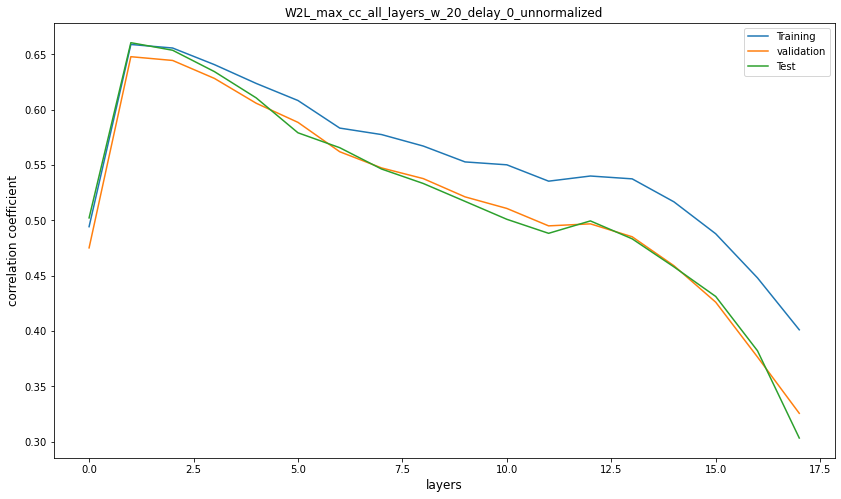

In [11]:
plt.figure(figsize=(14,8))
plt.plot(np.max(train_cc, axis=1), label='Training')
plt.plot(np.max(val_cc, axis=1), label='validation')
plt.plot(np.max(test_cc, axis=1), label='Test')
plt.legend(loc='best')
plt.title(f"W2L_max_cc_all_layers_w_{win}_delay_{delay}_unnormalized")
plt.xlabel("layers", fontsize=12)
plt.ylabel("correlation coefficient", fontsize=12)
# plt.savefig(os.path.join(results_dir, f"W2L_median_cc_all_layers_w_{win}_delay_{delay}_normalized"))

In [22]:
correlations = {'train': train_cc, 'val': val_cc, 'test': test_cc, 'win': win, 'delay': delay}

In [23]:
import pickle
# os.path.join(results_dir, f'w2l_all_cc_w_{win}_delay_{delay}_unnormalized')
save_cc_results(correlations, results_dir, win, delay)

In [8]:
def save_cc_results(corr, results_dir, win, delay):
    filename = os.path.join(results_dir, f'w2l_all_cc_w_{win}_delay_{delay}_unnormalized.pickle')
    with open(filename, 'wb') as f:
        pickle.dump(corr, f)
def read_cc_results(results_dir, win, delay):
    filename = os.path.join(results_dir, f'w2l_all_cc_w_{win}_delay_{delay}_unnormalized.pickle')
    with open(filename, 'rb') as f:
        corr = pickle.load(f)
    return corr
def plot_correlations(corr, metric='max'):
    win = corr['win']
    delay = corr['delay']
    train_cc = corr['train']
    val_cc = corr['val']
    test_cc = corr['test']
    if metric=='max':
        train = np.max(train_cc, axis=1)
        val = np.max(val_cc, axis=1)
        test = np.max(test_cc, axis=1)
    elif metric=='mean':
        train = np.mean(train_cc, axis=1)
        val = np.mean(val_cc, axis=1)
        test = np.mean(test_cc, axis=1)
    elif metric=='median':
        train = np.median(train_cc, axis=1)
        val = np.median(val_cc, axis=1)
        test = np.median(test_cc, axis=1)
    plt.figure(figsize=(14,8))
    plt.plot(train, label='Training')
    plt.plot(val, label='validation')
    plt.plot(test, label='Test')
    plt.legend(loc='best')
    plt.title(f"W2L_{metric}_cc_all_layers_w_{win}_delay_{delay}_unnormalized")
    plt.xlabel("layers", fontsize=12)
    plt.ylabel("correlation coefficient", fontsize=12)
    
def read_and_plot_correlations(results_dir, win, delay, metric='max'):
    corr = read_cc_results(results_dir, win, delay)
    plot_correlations(corr, metric)

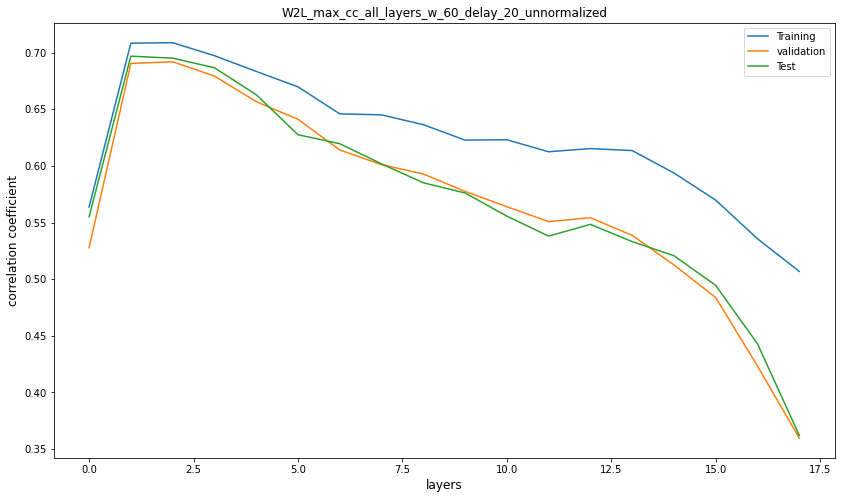

In [26]:
win=60
delay=20
read_and_plot_correlations(results_dir, win, delay, metric='max')

In [24]:
os.listdir(results_dir)

['w2l_all_cc_w_20_delay_0_unnormalized.pickle']

In [40]:
np.arange(0,10,5)

array([0, 5])

### Optimal 'delay' 

In [45]:
layer = 2
win = 20
ch = 32
delays = np.arange(0,100, 10)

num_delays = len(delays)
num_channels = obj.dataset.num_channels

In [47]:
train_cc = np.zeros((num_delays, num_channels))
val_cc = np.zeros((num_delays, num_channels))
test_cc = np.zeros((num_delays, num_channels)) 
for i,delay in enumerate(delays):
    train_cc[i,:], val_cc[i,:], test_cc[i,:] = obj.get_cc_norm_layer(layer, win, delay, normalize=False)

Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...
Computing correlations for layer:2 ...


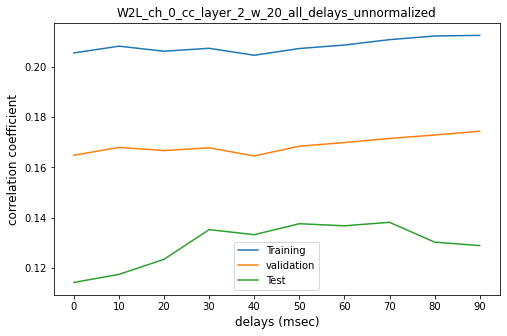

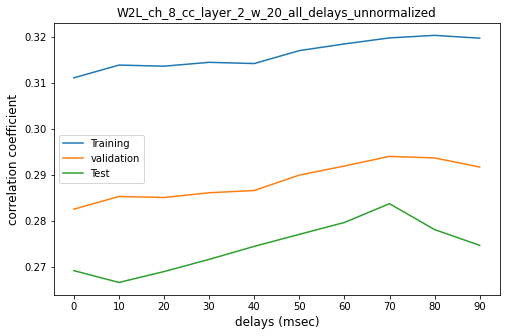

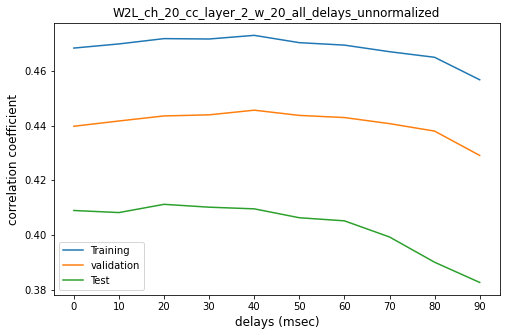

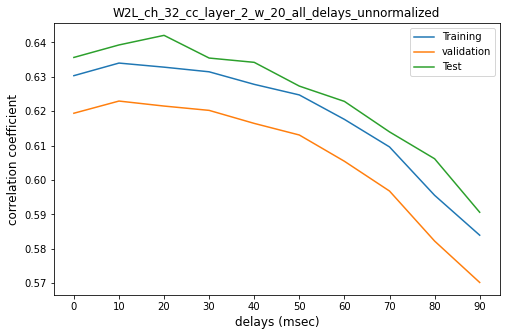

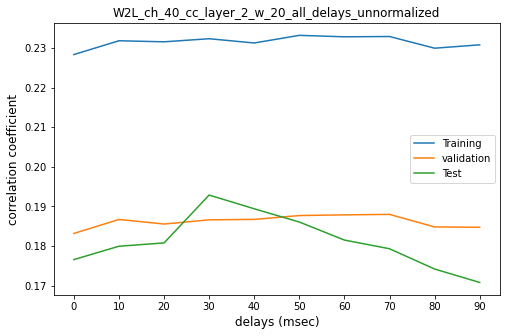

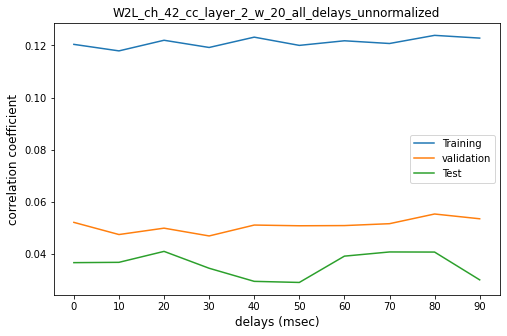

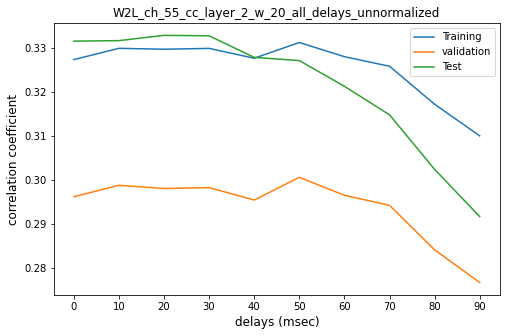

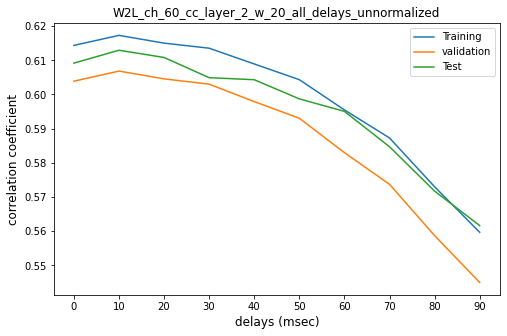

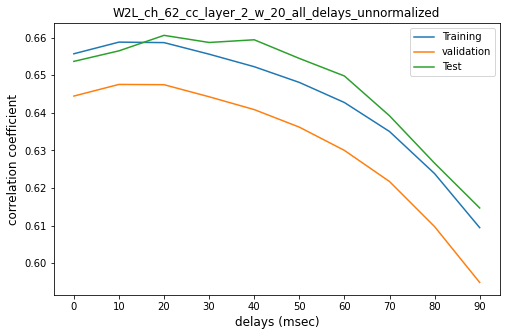

In [64]:
channels = [0,8,20,32,40,42,55,60,62]
for ch in channels:
    plt.figure(figsize=(8,5))
    plt.plot(train_cc[:,ch], label='Training')
    plt.plot(val_cc[:,ch], label='validation')
    plt.plot(test_cc[:,ch], label='Test')
    plt.legend(loc='best')
    plt.title(f"W2L_ch_{ch}_cc_layer_{layer}_w_{win}_all_delays_unnormalized")
    plt.xlabel("delays (msec)", fontsize=12)
    plt.xticks(np.arange(len(delays)), delays)
    plt.ylabel("correlation coefficient", fontsize=12)
    # plt.savefig(os.path.join(results_dir, f"W2L_median_cc_all_layers_w_{win}_delay_{delay}_normalized"))

### optimum bin width

In [ ]:
layer = 2
wins = [20, 40, 60, 80, 100, 120]
ch = 32
delay = 20

num_wins = len(wins)
num_channels = obj.dataset.num_channels

In [ ]:
train_cc = np.zeros((num_wins, num_channels))
val_cc = np.zeros((num_wins, num_channels))
test_cc = np.zeros((num_wins, num_channels)) 
for i,win in enumerate(wins):
    train_cc[i,:], val_cc[i,:], test_cc[i,:] = obj.get_cc_norm_layer(layer, win, delay, normalize=False)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.max(train_cc, axis=1), label='Training')
plt.plot(np.max(val_cc, axis=1), label='validation')
plt.plot(np.max(test_cc, axis=1), label='Test')
plt.legend(loc='best')
plt.title(f"W2L_max_cc_layer_{layer}_all_wins_delay_{delay}_unnormalized")
plt.xlabel("delays (msec)", fontsize=12)
plt.xticks(np.arange(len(wins)), wins)
plt.ylabel("correlation coefficient", fontsize=12)
# plt.savefig(os.path.join(results_dir, f"W2L_median_cc_all_layers_w_{win}_delay_{delay}_normalized"))

### Loading 'wav' file

In [4]:
s = 0
test_wav_files = os.path.join(model_param["data_dir"],'test_wav_files')
wav = os.path.join(test_wav_files, os.listdir(test_wav_files)[s])
fs, aud = wavfile.read(wav)

### Extract features

In [5]:
from Auditory_Cortex.auditory_cortex.feature_extractors import FeatureExtractorW2L
extractor = FeatureExtractorW2L(mod)

In [6]:
out = extractor(aud)

In [13]:
extractor.get_features

torch.Size([1024, 69])

In [14]:
extractor.features[extractor.layers[0]].shape

torch.Size([256, 69])

In [5]:
# mod = LitWav2Letter(model_param)

In [14]:
wav = os.path.join(test_wav_files, os.listdir(test_wav_files)[0])

In [22]:
from scipy.io import wavfile
fs, aud = wavfile.read(wav)

In [23]:
from IPython.display import Audio
Audio(aud, rate=fs)

In [9]:

print(os.listdir(test_wav_files)[s])
x = torch.tensor(aud, dtype=torch.float32)
x = x.unsqueeze(dim=0)
mod.decode(x)

have_you_got_enough_blankets.wav


['tre the doniy ofh blanketse ']

In [53]:
pred

['wre te dyvian of blaingets ur']

NameError: name 'torch' is not defined

In [14]:
mod.named_children

<bound method Module.named_children of LitWav2Letter(
  (loss_fn): CTCLoss()
  (transform): Spectrogram()
  (conv1): conv_block(
    (conv): Conv1d(161, 256, kernel_size=(11,), stride=(2,), padding=(5,))
    (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (conv2): conv_block(
    (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
    (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (conv3): conv_block(
    (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
    (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (conv4): conv_block(
    (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,

In [15]:
dict([*mod.named_children()])['transform']

Spectrogram()

In [72]:
dict([*mod.named_children()])

{'loss_fn': CTCLoss(),
 'transform': Spectrogram(),
 'conv1': conv_block(
   (conv): Conv1d(161, 256, kernel_size=(11,), stride=(2,), padding=(5,))
   (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (activation): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 'conv2': conv_block(
   (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
   (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (activation): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 'conv3': conv_block(
   (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
   (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (activation): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 'conv4': conv_block(
   (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
   (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=

In [6]:
print(mod)

LitWav2Letter(
  (loss_fn): CTCLoss()
  (transform): Spectrogram()
  (conv1): conv_block(
    (conv): Conv1d(161, 256, kernel_size=(11,), stride=(2,), padding=(5,))
    (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (conv2): conv_block(
    (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
    (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (conv3): conv_block(
    (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
    (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (conv4): conv_block(
    (conv): Conv1d(256, 256, kernel_size=(11,), stride=(1,), padding=(5,))
    (batch_norm): Batc

In [ ]:
dm = LSDataModule(model_param)

In [ ]:
import pytorch_lightning as pl

In [43]:
df = pd.DataFrame(columns=["epoch", 'CER', 'WER'])
df.head()

,epoch,CER,WER


In [44]:
dir = '/scratch/gilbreth/ahmedb/wav2letter/puzzlelib_saved_results'
filename = os.path.join(dir, "results.txt")
count = 0
items = 0
with open(filename, 'r') as f:
    for line in f.readlines():
        if line[0].lower() =='t':
            lis = line.split()
            entry = {'epoch': items*10, 'CER': float(lis[4].replace(',', '')), 'WER': float(lis[6])}
            # print(lis[4].replace(',', ''))
            # print(lis[6])
            df = df.append(entry, ignore_index=True)
            items +=1 
        # count +=1
        # if count > 5:
        #     break

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(df['epoch'], df['CER'])
df.plot(x='epoch', y=['CER', 'WER'])
plt.title("W2L for 'train_clean_100' and batch=8")
plt.ylabel("Error Rate")


In [ ]:
df['CER']

In [ ]:
df.head()

In [2]:
def create_manifest(url):
    df = pd.DataFrame(columns=['audio','trans','len'])
    path = os.path.join(data_dir, 'LibriSpeech', url)
    speakers = os.listdir(path)
    for speaker in speakers:
        chapters = os.listdir(os.path.join(path,speaker))
        for chapter in chapters:
            filename = os.path.join(path, speaker, chapter, f"{speaker}-{chapter}.trans.txt")
            with open(filename) as file:
                lines = file.readlines()
            for line in lines:
                data = line.strip("\n").split(" ", 1)
                audio = os.path.join(path, speaker, chapter, f"{data[0]}.flac")
                df.loc[len(df.index)] = [audio,data[1], len(data[1])]
    return df

In [3]:
dataframes = []
for url in urls:
    dataframes.append(create_manifest(url))
manifest = pd.concat(dataframes)
# df = create_manifest(urls[0])
manifest.sort_values(by=['len'], inplace=True)
manifest.set_index(['audio','trans','len'], inplace=True)
manifest.to_csv(os.path.join(data_dir,'train_manifest.csv'))

In [5]:
def prepare_LibriSpeech_dataset(urls, filename):
    dataframes = []
    for url in urls:
        dataframes.append(create_manifest(url))
    manifest = pd.concat(dataframes)
    # df = create_manifest(urls[0])
    manifest.sort_values(by=['len'], inplace=True)
    manifest.set_index(['audio','trans','len'], inplace=True)
    manifest.to_csv(os.path.join(data_dir,filename))

In [6]:
prepare_LibriSpeech_dataset(val_url, 'val_manifest.csv')

In [ ]:
prepare_LibriSpeech_dataset(test_url, 'test_manifest.csv')

In [30]:
manifest = pd.read_csv(os.path.join(data_dir,'manifest.csv'))

In [32]:
len(manifest)

132553

In [14]:
filename = manifest.iloc[1000]['audio']

In [29]:
data, fs = soundfile.read(filename)

In [35]:
class LibriSpeechDataset():
    def __init__(self, manifest):
        self.manifest = pd.read_csv(manifest)
    
    def __len__(self):
        return len(self.manifest)
        
    def __getitem__(self, idx):
        audio_path = self.manifest.iloc[idx]['audio']
        trans = self.manifest.iloc[idx]['trans']
        audio, fs = soundfile.read(audio_path)
        return audio, trans, fs

In [36]:
dataset = LibriSpeechDataset(os.path.join(data_dir,'manifest.csv'))

In [39]:
wav, tra, fs = dataset.__getitem__(10)

In [40]:
wav.shape

(21280,)

In [ ]:
import IPython
IPython.display.Audio(data, rate=fs, autoplay=True)

In [28]:
import numpy as np
from IPython.display import Audio
framerate = 44100
t = np.linspace(0,5,framerate*5)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
Audio(data,rate=framerate)